In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.family']=['SimHei','Times New Roman']
plt.rcParams['axes.unicode_minus']=False
import warnings
warnings.filterwarnings(action='ignore')
np.random.seed(42)

## 读取手写数据集
- 灰度图数据集(28,28,1)

In [2]:
from sklearn.datasets import fetch_openml

# 从 OpenML 获取 MNIST 数据集
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# 查看数据集的基本信息
print(f"数据集键: {list(mnist.keys())}")
print(f"数据形状: {mnist.data.shape}")
print(f"标签形状: {mnist.target.shape}")

数据集键: ['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url']
数据形状: (70000, 784)
标签形状: (70000,)


In [3]:
X,y=mnist["data"],mnist["target"]

## 交叉验证原理
- ![1](img/img_3.png)
- ![2](img/img_4.png)

In [4]:
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]
import numpy as np
shuffle_index=np.random.permutation(60000)
X_train,y_train=X_train[shuffle_index],y_train[shuffle_index]

In [23]:
y_train_5 = (y_train=='5')
y_test_5 = (y_test=='5')

In [24]:
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(max_iter=5,random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(max_iter=5, random_state=42)

In [25]:
sgd_clf.predict([X[3500]])

array([ True])

In [26]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.964 , 0.9579, 0.9571])

## 混淆矩阵
- 混淆矩阵
- ![1](img/img_5.png)

- 顺序
    - [true_negative, false_positive]
    - [false_negative, true_positive]

In [27]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
confusion_matrix(y_train_5,y_train_pred)

array([[54058,   521],
       [ 1899,  3522]])

## Precison and Recall
- $precision = \frac{TP}{TP + FP}$
- $recall = \frac{TP}{TP + FN}$

In [29]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5,y_train_pred),recall_score(y_train_5,y_train_pred)

(0.8711352955725946, 0.6496956281128943)

## F1 score
- 调和平均值给予低值更多的权重，因此召回和精确度都很高时，F1 score会更高。
- $F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2\times\frac{precision\times recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$

In [30]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7442941673710904

对得分值设置一个阈值

In [31]:
y_scores=sgd_clf.decision_function([X[3500]])
y_scores

array([56879.22254847])

In [34]:
y_pred=(y_scores>50000)
y_pred

array([ True])

In [37]:
y_scores=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")
y_scores[:10]

array([ -545086.1906455 ,  -200238.20632717,  -366873.76172794,
        -648828.94558457,  -572767.52239341, -1016184.25580999,
        -419438.40135301,  -171080.39957192,   237230.03978349,
        -793932.50331372])

In [38]:
from sklearn.metrics import precision_recall_curve
precision,recall,thresholds=precision_recall_curve(y_train_5,y_scores)

In [39]:
thresholds.shape #可以设置的阈值

(60000,)

In [40]:
precision.shape,recall.shape #精度和召回

((60001,), (60001,))

随着阈值增加，精度会越来越高，召回率会越来越低

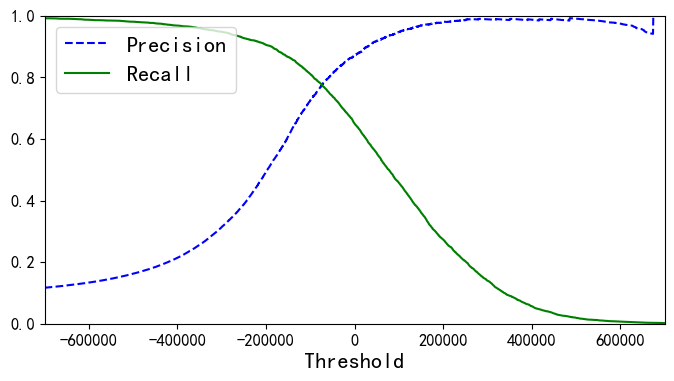

In [41]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds,
             precisions[:-1],
             "b--",
             label="Precision")

    plt.plot(thresholds,
             recalls[:-1],
             "g-",
             label="Recall")
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precision, recall, thresholds)
plt.xlim([-700000, 700000])
plt.show()

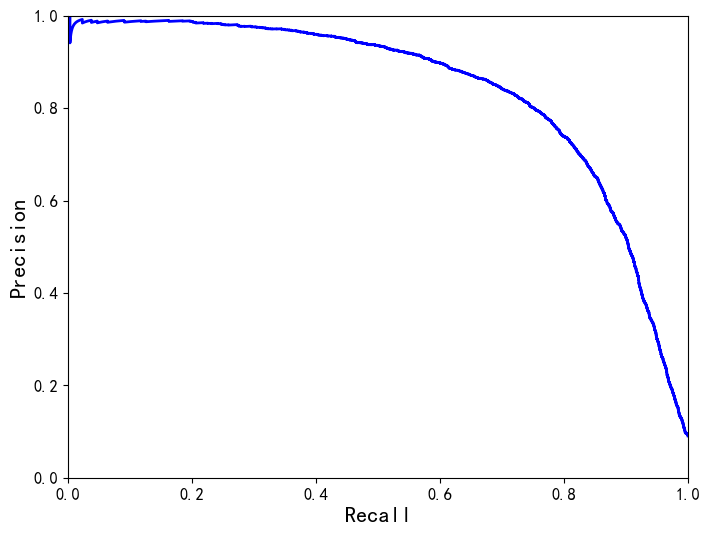

In [42]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls,
             precisions,
             "b-",
             linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precision, recall)
plt.show()

## ROC曲线
- 最好的一个分类器应该是左上角去的， Roc曲线越向左上角，说明越好

In [43]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

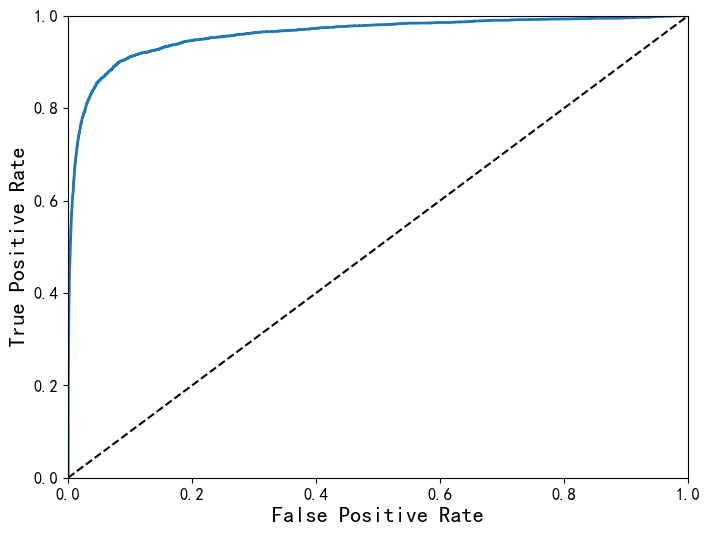

In [44]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [45]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9598058535696421)